In [1]:
import cirq
import matplotlib.pyplot as plt
import numpy as np
from math import gcd
from fractions import Fraction
import pandas as pd
from numpy.random import randint
from cirq.contrib.svg import SVGCircuit # Cette librairie sera utilisée pour afficher les circuits quantiques d'une manière plus lisible.

In [2]:
qubits_de_calcul = 8
qubits_de_comparaison = 4
nb_qubits = qubits_de_calcul+qubits_de_comparaison # le nombre de qubits pour représenter le binaire secret.
qubits = cirq.LineQubit.range(nb_qubits) # Création des qubits.
a = 7

In [3]:
class AMod15(cirq.Gate):
    def __init__(self,a,exposant):
        super(AMod15, self)
        self.a = a
        self.exposant = exposant

    def _num_qubits_(self):
        return 4

    def _decompose_(self, qubits):
        """Une porte controllé par a mod 15"""
        q0,q1,q2,q3 = qubits
        a=self.a
        power=self.exposant
        if a not in [2,4,7,8,11,13]:
            raise ValueError("'a' doit être: 2,4,7,8,11 or 13")
        for _iteration in range(power):
            if a in [2,13]:
                yield cirq.SWAP(q2,q3)
                yield cirq.SWAP(q1,q2)
                yield cirq.SWAP(q0,q1)
            if a in [7,8]:
                yield cirq.SWAP(q0,q1)
                yield cirq.SWAP(q1,q2)
                yield cirq.SWAP(q2,q3)
            if a in [4, 11]:
                yield cirq.SWAP(q1,q3)
                yield cirq.SWAP(q0,q2)
            if a in [7,11,13]:
                for q in range(4):
                    yield cirq.X(qubits[q])

    def _circuit_diagram_info_(self, args):
        return [str(self.a)+"^"+str(self.exposant)+" mod 15"] * self.num_qubits()

In [51]:
class QFTDagger(cirq.Gate):
    def __init__(self,n):
        super(QFTDagger, self)
        self.n = n

    def _num_qubits_(self):
        return self.n

    def _decompose_(self, qubits):
        """Une porte qui permet de faire l'inverse de la transformée de Fourier quantique"""
        for qubit in range(self.n//2):
            yield cirq.SWAP(qubits[qubit], qubits[self.n-qubit-1])
        for j in range(self.n):
            for m in range(j):
                yield cirq.cphase(-np.pi/float(2**(j-m))).on(qubits[j], qubits[m])
            yield cirq.H(qubits[j])

    def _circuit_diagram_info_(self, args):
        return ["QFT†"] * self.num_qubits()

In [52]:
"""Applique la phase initial pour le circuit de Shor"""
def phase_initial():
    for i in range(8):
        yield cirq.H(qubits[i])
    yield cirq.X(qubits[nb_qubits-qubits_de_comparaison])

In [53]:
def applique_porte_a_mod15_controlle():
    for q in range(nb_qubits-4):
        yield cirq.ControlledGate(sub_gate=AMod15(a=a,exposant=2**q), num_controls=1).on(qubits[q], qubits[qubits_de_calcul], qubits[qubits_de_calcul+1], qubits[qubits_de_calcul+2], qubits[qubits_de_calcul+3])

Circuit:


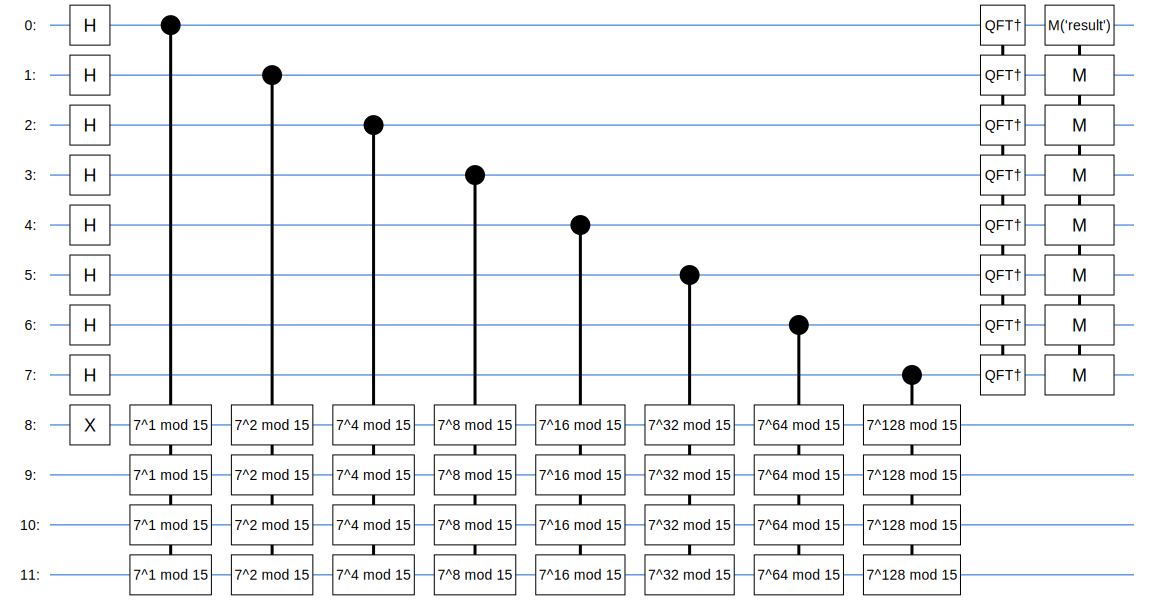

In [54]:
circuit = cirq.Circuit(
    phase_initial(),
    applique_porte_a_mod15_controlle(),
    QFTDagger(qubits_de_calcul)(*qubits[0:qubits_de_calcul]),
    cirq.measure(*qubits[0:8], key='result')
)

print("Circuit:")
SVGCircuit(circuit)

Circuit simulé:
measurements: result=00000011

qubits: (cirq.LineQubit(0),)
output vector: -1|0⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |0⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: |0⟩

qubits: (cirq.LineQubit(5),)
output vector: |0⟩

qubits: (cirq.LineQubit(6),)
output vector: |1⟩

qubits: (cirq.LineQubit(7),)
output vector: |1⟩

qubits: (cirq.LineQubit(8), cirq.LineQubit(9), cirq.LineQubit(10), cirq.LineQubit(11))
output vector: 0.5|0010⟩ - 0.5|1000⟩ + 0.5j|1011⟩ - 0.5j|1110⟩

phase:
output vector: |⟩
Counter({2: 256, 0: 255, 1: 251, 3: 238})


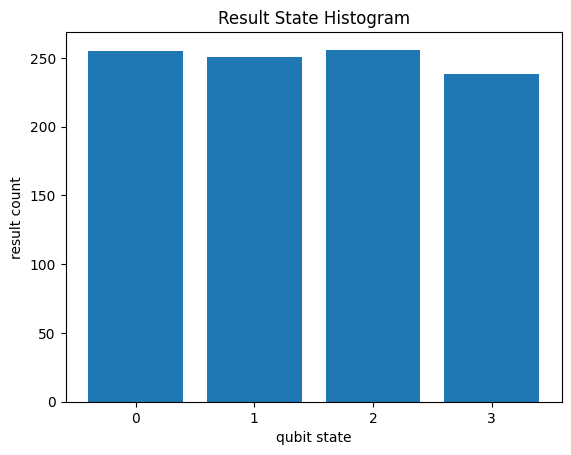

In [55]:
# On initialise le simulateur.
simulateur = cirq.Simulator()

print('Circuit simulé:')
resultats = simulateur.simulate(circuit)
print(resultats)

# On fait les essayes du circuit.
essaies = simulateur.run(circuit, repetitions=1000)

# On vient chercher seulement les qubits qui ont un résultats.
counts = essaies.histogram(key='result')
print(counts)


# On affiche les résultats dans un graphique.
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

In [56]:
# Cette partie permet d'inverser l'ordre des qubits pour avoir le résultat en binaire comme dans qiskit
# Après elle crée un tableau.
colonne = []
for reponse in counts.keys():
    phase = int(format(reponse, "0"+str(qubits_de_calcul)+"b")[::-1],2)
    fraction = Fraction(phase/2**(nb_qubits-4)).limit_denominator(15)
    colonne.append([phase,
                f"{fraction.numerator}/{fraction.denominator}",
                fraction.denominator])
entete=["Phase", "Fraction", "Supposition pour r"]
df = pd.DataFrame(colonne, columns=entete)
print(df)

   Phase Fraction  Supposition pour r
0    192      3/4                   4
1      0      0/1                   1
2     64      1/4                   4
3    128      1/2                   2


In [57]:
def a2jmodN(a, j, N):
    """Effectue le calcul de a^{2^j} (mod N) par des carrés répétés"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [58]:
print(a2jmodN(7, 2049, 53))

47


In [59]:
N = 15
np.random.seed(1) # Permet d'avoir toujours le même nombre aléatoire.
a = randint(2, 15)
print(a)

7


In [60]:
gcd(a, N)

1

In [61]:
def qpe_amod15(a):
    """Effectue l'estimation de phase quantique sur l'opération a*r mod 15.
    Args:
        a (int): C'est le 'a' dans a*r mod 15
    Returns:
        float: L'estimation de la phase
    """
    N_COUNT = 8
    qubits = cirq.LineQubit.range(N_COUNT+4)

    def algo():
        for q in range(N_COUNT):
            yield cirq.H(qubits[q])
        yield cirq.X(qubits[N_COUNT+3])
        for q in range(N_COUNT):
            yield cirq.ControlledGate(sub_gate=AMod15(a=a,exposant=2**q), num_controls=1).on(qubits[q], qubits[N_COUNT], qubits[N_COUNT+1], qubits[N_COUNT+2], qubits[N_COUNT+3])
        yield QFTDagger(N_COUNT)(*qubits[0:N_COUNT])
        yield cirq.measure(*qubits[0:N_COUNT], key='result')
    
    circuit = cirq.Circuit(algo())

    # On fait les essayes du circuit.
    essaies = simulateur.run(circuit, repetitions=1000)

    # On vient chercher seulement les qubits qui ont un résultats.
    counts = essaies.histogram(key='result')
    print(counts)

    reading = str(int(format(list(counts.keys())[0], "0"+str(qubits_de_calcul)+"b")[::-1],2))
    print("Register Reading: " + reading)
    phase = int(reading)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [62]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Counter({0: 272, 2: 246, 3: 241, 1: 241})
Register Reading: 192
Corresponding Phase: 0.75


Fraction(3, 4)

In [63]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [64]:
suppositions = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(suppositions)

[3, 5]


In [67]:
a = 7
FACTOR_TROUVE = False
ESSAIE = 0
while not FACTOR_TROUVE:
    ESSAIE += 1
    print(f"\nESSAIE {ESSAIE}:")
    phase = qpe_amod15(a) # Phase = s/r
    fraction = Fraction(phase).limit_denominator(N)
    r = fraction.denominator
    print(f"Résultat: r = {r}")
    if phase != 0:
        # Suppositions pour les facteurs sont gcd(x^{r/2} ±1 , 15)
        suppositions = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {suppositions[0]} and {suppositions[1]}")
        for supposition in suppositions:
            if supposition not in [1,N] and (N % supposition) == 0:
                # Guess is a factor!
                print(f"*** Facteur non-triaval trouver: {supposition} ***")
                FACTOR_TROUVE = True


ESSAIE 1:
Counter({0: 256, 2: 254, 1: 251, 3: 239})
Register Reading: 0
Corresponding Phase: 0.0
Résultat: r = 1

ESSAIE 2:
Counter({1: 258, 3: 256, 0: 246, 2: 240})
Register Reading: 64
Corresponding Phase: 0.25
Résultat: r = 4
Guessed Factors: 3 and 5
*** Facteur non-triaval trouver: 3 ***
*** Facteur non-triaval trouver: 5 ***
